# This notebook mines trends from annoted tweets as well as generates relevant plots vs the government data

In [41]:
%%time 

import pandas as pd
import geocoder
import numpy as np
import os
import json
import datetime 
import matplotlib.pyplot as plt

government_data_dir = './vaccine_data/hhs_data/'


CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 18.8 µs


In [9]:
def week_num_from_start_date(curr_date,start_date):
    '''Returns the number of weeks from start date'''
    date_delta = datetime.datetime.strptime(curr_date , '%Y_%m_%d') - start_date
    return (date_delta.days//7+1)

In [24]:
def is_tweet_matching_annotation(tweet_annotations,tweet_prop_config):
    '''Given Set of annotaions and '''
    # matches_correct_prop:
    for key in tweet_prop_config.keys():
        if tweet_annotations[key]['label'] not in tweet_prop_config[key]:
            return False
    return True


In [25]:
tweet_labels = ['flu_annotator', 'decision_type_who', 'flu_vaccine_received', 'location', 'sentiment', 
 'decision_type_sentiment_nonneutral', 'flu_vaccine_sentiment', 'vaccine_annotator', 
 'flu_vaccine_intent_to_receive', 'flu_vaccine_relevant', 'who', 
 'relevant', 'decision_type_relevant', 'decision_type_sentiment']




# Possible tweet configs
### Link to document for label reference -->https://bitbucket.org/mdredze/falconet/src/master/README.data.md

    1. ['flu_vaccine_relevant']=[True]
    2. ['flu_vaccine_received'] = [True]
    3. ['flu_vaccine_relevant']=[True] and ['flu_vaccine_intent_to_receive']=[True]
    4. ['flu_vaccine_received'] = [True] and ['flu_vaccine_relevant']=[True] and    ['flu_vaccine_intent_to_receive']=[True]
    5. ['flu_vaccine_relevant']=[True] and ['flu_vaccine_sentiment']=["positive"]


In [40]:
%%time 
tweet_prop_config={}

tweet_prop_config['flu_vaccine_relevant']=[True]
tweet_prop_config['flu_vaccine_sentiment']=["positive"]

curr_dir = 'mined_tweets/output_dir/tweets/'
years_dirs=[curr_dir+'201'+str(i)+'/' for i in range(2,8)]
trends_count = {}
for year_d in years_dirs:
    year = year_d[-5:-1]
    trends_count[year]={}
    months  = os.listdir(year_d)
    if '.DS_Store' in months:
        months.remove('.DS_Store')
    for month_num in months:
        for tweet_file in sorted(os.listdir(year_d+month_num)):
            day = tweet_file[:10]
            with open(year_d+month_num+'/'+tweet_file,'r') as f:
                for line in f:
                    t_d = json.loads(line)
                    if 'location' in t_d['annotations'] and \
                        t_d['annotations']['location']['country']=='United States':
                        state = t_d['annotations']['location']['state']
                        # print(tweet_file)
                        if state!='':
                            if state not in trends_count[year]:
                                trends_count[year][state]={}
                                #print(f_name)
                            if is_tweet_matching_annotation(t_d['annotations'],tweet_prop_config):
                                trends_count[year][state][day]=trends_count[year][state].get(day,0)+1

                    
                            
val_list = []
for year,year_item in trends_count.items():
    for state,state_item in year_item.items():
        for date,count in state_item.items():
            list_el = {}
            list_el['state']=state
            list_el['date']=date
            list_el['count']=count
            list_el['year']=year
            val_list.append(list_el)
            
tweet_trend_df = pd.DataFrame(val_list)
tweet_trend_df.to_csv("mined_trends/flu_vaccine_received_relevant_positive_sentiment.csv")
      
print('line read and check time')        

line read and check time
CPU times: user 1min 10s, sys: 5.21 s, total: 1min 15s
Wall time: 1min 31s


# Government Trends vs Tweet Trends

In [38]:
def plot_national_trends_vs_tweet_csv(tweet_file_names):
    '''Takes as input the tweets csv name to plots government trends against it '''
    train_years = [2013,2014]
    dev_years = [2015]
    test_years = [2016]
    train_download_dir = ('train',train_years)
    dev_download_dir = ('dev',dev_years)
    test_download_dir = ('test',test_years)
    data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

    for tweet_file_name in tweet_file_names:
        tweets_df = \
            pd.read_csv(tweet_file_name,index_col=['Unnamed: 0'])

    
    for data_split in data_split_ls:
        split,years = data_split
        for year in years:
            fig=plt.figure( dpi= 100)
            government_data_df = pd.read_json(open(os.path.join(government_data_dir,split,str(year),'national.json')))
            government_df_start_date = government_data_df.loc[0,'week_start']

            government_df_start_date = datetime.datetime.strptime("{}_{}".\
                                                                  format(year-1,government_df_start_date) , '%Y_%d%b')

            count_vaccinated_week = (government_data_df['percentage']*government_data_df['count']).values
            count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
            count_vaccinated_week[0]=0
            count_vaccinated_week_notmalized = count_vaccinated_week/count_vaccinated_week.sum()
            plt.plot(government_data_df['week'],count_vaccinated_week_notmalized,label='Government Vaccination in {}'.format(year));

            for tweet_file_name in tweet_file_names:
                tweets_df = pd.read_csv(tweet_file_name,index_col=['Unnamed: 0'])

                curr_tweet_df = tweets_df[tweets_df['year'].isin([year-1,year])]
                curr_tweet_df['week_number']=curr_tweet_df['date'].apply(lambda x: week_num_from_start_date(x,government_df_start_date))
                curr_tweet_df=curr_tweet_df[(curr_tweet_df['week_number']>0) & (curr_tweet_df['week_number']<53)]
                curr_tweet_df = curr_tweet_df.groupby('week_number',as_index=False)['count'].sum()
                count_tweets_week= curr_tweet_df['count']/curr_tweet_df['count'].sum()
                plt.plot(government_data_df['week'],count_tweets_week,label='{}'.format(tweet_file_name[:-4]));
            
            plt.title("Year = {}".format(year))
            
            plt.ylabel('Normalized Score')
            plt.xlabel('Weeks, starting from aug-1')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()


# National Trends vs flu vaccine relevant and flu_vaccine_recieved_true

/Users/jawa/anaconda2/envs/eff_treat/lib/python3.6/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


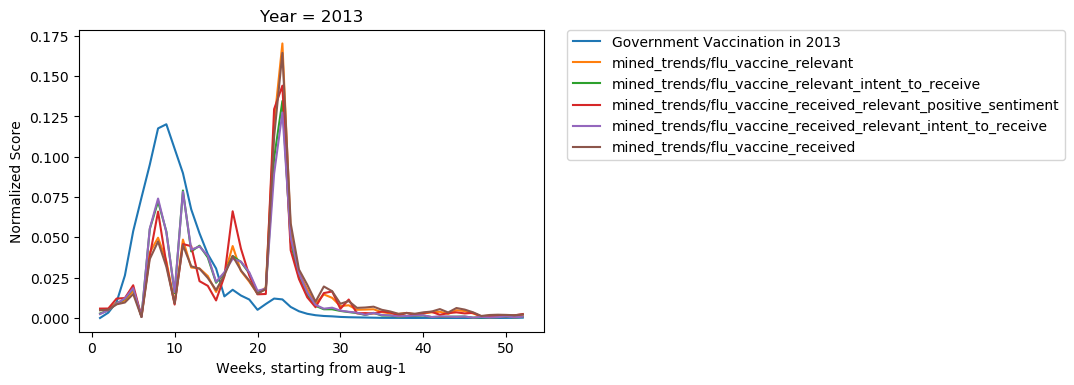

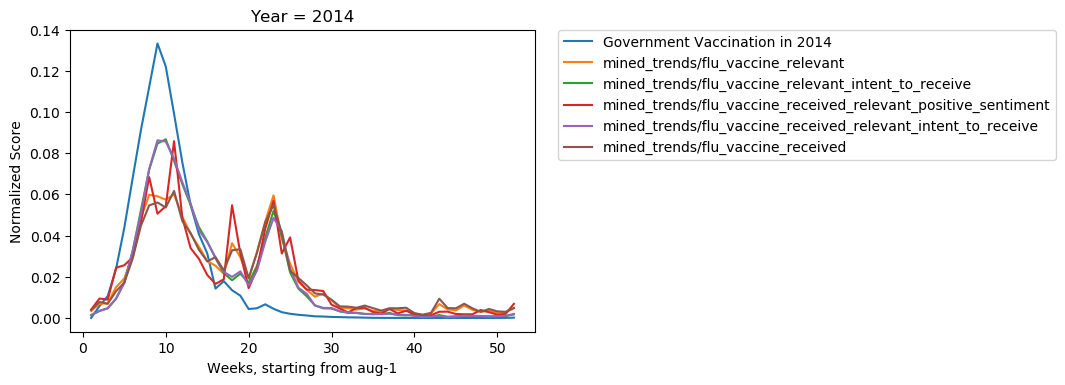

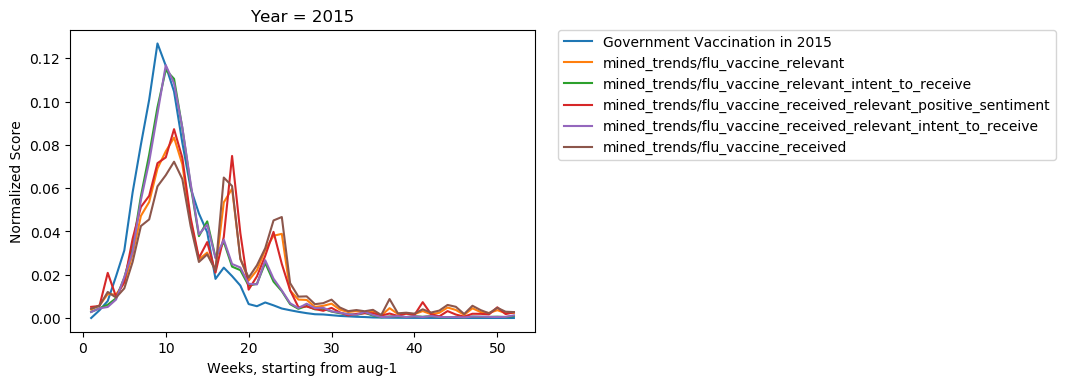

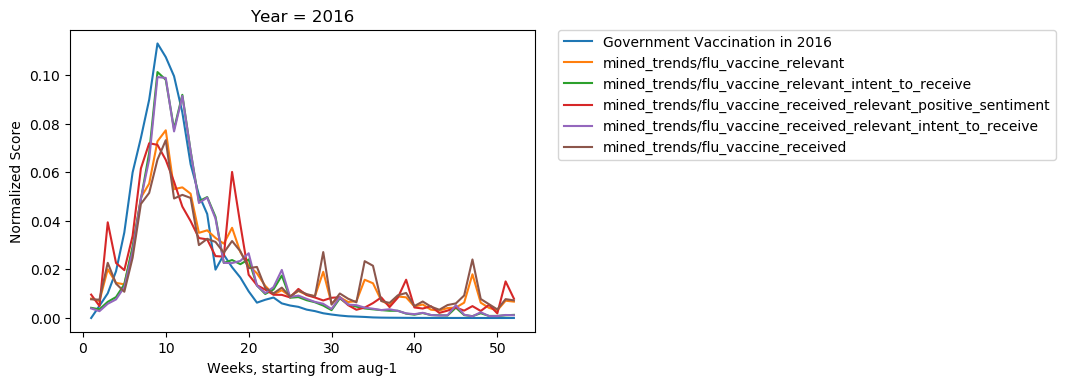

In [43]:
curr_files_list = os.listdir('mined_trends')
curr_files_list = ["mined_trends/{}".format(x) for x in curr_files_list if '.csv' in x]
plot_national_trends_vs_tweet_csv(curr_files_list)